# Better Reads: Improving on Amazon/GoodReads reccomendation system
---

# <a class="anchor" id="table_of_contents"> Table of Contents </a>
* [Background](#background)
* [Initial Imports](#imports)
* [Import Data](#import_data)
* [Pickles](#pickles)
* [Create GoodReads-10k Dataframe](#goodreads)
* [Consolidate Data](#consolidate)
* [Modeling](#modeling)
* [Create Interactions](#interactions)

#### Goal: 
Recommendations should help a customer find and discover new, relevant, and interesting items. Popular items by the same author or in the same subject category fail to achieve this goal
* Eliminate the same author recommendations
* Eliminate prior kindle purchases as recommendations
* Consider Author reccomendations instead of book reccomendations
* Experimental variable: To compensate for best-selling items, the algorithm typically multiplies the vector components by the inverse frequency (the inverse of the number of customers who have purchased or rated the item), making less well-known items much more relevant.

#### Plan:
1. collaborative filtering  model first
2.	NLP topic analysis
4.	try to make this:  
a.	http://datasqz.com/movie-names/movie-similar  
b. https://philippsp.shinyapps.io/BookRecommendation/  
c. http://www.benfrederickson.com/venn-diagrams-with-d3.js/

---

# <a class="anchor" id="background"> Background </a>
#### [Table of Contents](#table_of_contents) 
---

#### Recommendation Algorithms
Most recommendation algorithms start by finding
a set of customers whose purchased and rated
items overlap the user’s purchased and rated
items. The algorithm aggregates items from these
similar customers, eliminates items the user has
already purchased or rated, and recommends the
remaining items to the user. Two popular versions
of these algorithms are collaborative filtering and
cluster models. Other algorithms — including
search-based methods and our own item-to-item
collaborative filtering — focus on finding similar
items, not similar customers. For each of the user’s
purchased and rated items, the algorithm attempts
to find similar items. It then aggregates the similar
items and recommends them.


#### item-to-item:
item-to-item collaborative filtering matches each of the user’s purchased and rated items to similar items, then combines those similar items into a recommendation list

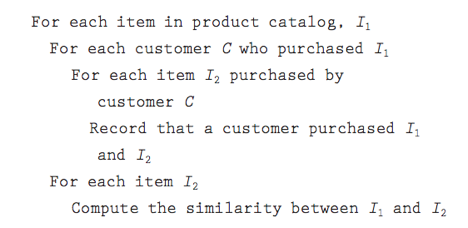

It’s possible to compute the similarity between two items in various ways, but a common method is to use the cosine measure we described earlier, in which each vector corresponds to an item rather than a customer, and the vector’s M dimensions correspond to customers who have purchased that item. This offline computation of the similar-items table is extremely time intensive, with $ O(N^2 M)$ as worst case. In practice, however, it’s closer to $ O(NM) $, as most customers have very few purchases. Sampling customers who purchase best-selling titles reduces runtime even further, with little reduction in quality. Given a similar-items table, the algorithm finds items similar to each of the user’s purchases and ratings, aggregates those items, and then recommends the most popular or correlated items. This computation is very quick, depending only on the number of items the user purchased or rated.

#### Existing methods fall short:
- Traditional collaborative filtering does little or
no offline computation, and its online computation
scales with the number of customers and
catalog items. The algorithm is impractical on
large data sets, unless it uses dimensionality
reduction, sampling, or partitioning — all of
which reduce recommendation quality.
- Cluster models can perform much of the computation
offline, but recommendation quality
is relatively poor. To improve it, it’s possible to
increase the number of segments, but this
makes the online user–segment classification
expensive.
- Search-based models build keyword, category,
and author indexes offline, but fail to provide
recommendations with interesting, targeted
titles. They also scale poorly for customers with
numerous purchases and ratings.

The key to item-to-item collaborative filtering’s
scalability and performance is that it creates the
expensive similar-items table offline. 

The algorithm’s
online component — looking up similar
items for the user’s purchases and ratings — scales
independently of the catalog size or the total number
of customers; it is dependent only on how
many titles the user has purchased or rated. Thus,
the algorithm is fast even for extremely large data
sets. Because the algorithm recommends highly
correlated similar items, recommendation quality
is excellent. 

Unlike traditional collaborative filtering,
the algorithm also performs well with limited
user data, producing high-quality recommendations
based on as few as two or three items.

#### As the Netflix Prize competition has demonstrated,
matrix factorization models
are superior to classic nearest-neighbor
techniques for producing product recommendations,
allowing the incorporation
of additional information such as implicit
feedback, temporal effects, and confidence
levels


### Modeling Notes


#### explicit vs implicit

It is worth knowing that models using explicit ratings have fallen out of favour both in academia and in industry. It is now widely accepted that what people choose to interact with is more meaningful than how they rate the interactions they have.

#### which scoring metric?

Mean reciprocal rank (MRR) gives you a general measure of quality in these situations, but MRR only cares about the single highest-ranked relevant item. If your system returns a relevant item in the third-highest spot, that's what MRR cares about. It doesn't care if the other relevant items (assuming there are any) are ranked number 4 or number 20.

Therefore, MRR is appropriate to judge a system where either (a) there's only one relevant result, or (b) in your use-case you only really care about the highest-ranked one. This might be true in some web-search scenarios, for example, where the user just wants to find one thing to click on, they don't need any more. (Though is that typically true, or would you be more happy with a web search that returned ten pretty good answers, and you could make your own judgment about which of those to click on...?)

Mean average precision (MAP) considers whether all of the relevant items tend to get ranked highly. So in the top-20 example, it doesn't only care if there's a relevant answer up at number 3, it also cares whether all the "yes" items in that list are bunched up towards the top.

There's no real need to use MAP if you only ever have 1 relevant answer in your data, MRR would be fine. But if you submit a query such as "female heads of state" and the top three results are "Margaret Thatcher", "Vigdís Finnbogadóttir", and "Pratibha Patil", those all are distinct but correct answers, and we might want to judge this as a good result, better than a system which only floated one of those answers to the top.

#### which loss fuctions?
The pointwise, BPR, and hinge losses are a good fit for implicit feedback models trained through negative sampling.

The regression and Poisson losses are used for explicit feedback models.



### Citations
---

#### Data sources:
- http://jmcauley.ucsd.edu/data/amazon/
- https://github.com/zygmuntz/goodbooks-10k
- https://www.kaggle.com/gnanesh/goodreads-book-reviews/home

#### Background info:
- Greg Linden, Brent Smith, and Jeremy York. Amazon.com Recommendations Item-to-Item Collaborative Filtering.  IEEE Computer Society, 2003
- R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016
- J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015

#### Code resources:
- https://github.com/benfred/implicit

---

# <a class="anchor" id="imports"> Initial Imports </a>
#### [Table of Contents](#table_of_contents) 
---

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle
import os
import implicit
import time
import timeit
import json
import multiprocessing as mp
pd.set_option("display.max_colwidth", 10000)

def parse(path):
    g = open(path, 'r')
    for l in g:
        yield json.dumps(eval(l))
        
def convert_json(path):
    f = open("converted.json", 'w')
    for l in parse(path):
        f.write(l + '\n')

# <a class="anchor" id="import_data"> Import Data </a>
#### [Table of Contents](#table_of_contents) 
---

In [28]:
%time reviews_kindle = pd.read_json('reviews_kindle.json',lines=True)

CPU times: user 1min 8s, sys: 2.45 s, total: 1min 10s
Wall time: 56.5 s


In [29]:
%time reviews_goodreads_small = pd.read_csv('reviews_goodreads.csv',  engine='python', error_bad_lines= False)

Skipping line 312075: unexpected end of data


CPU times: user 7.08 s, sys: 116 ms, total: 7.2 s
Wall time: 4.68 s


In [30]:
%%time
convert_json("meta_kindle.json")
meta_kindle = pd.read_json('converted.json', lines=True, orient='records')
meta_kindle.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434702 entries, 0 to 434701
Data columns (total 9 columns):
asin           434702 non-null object
brand          5 non-null object
categories     434702 non-null object
description    92886 non-null object
imUrl          432711 non-null object
price          266773 non-null float64
related        355407 non-null object
salesRank      34 non-null object
title          44 non-null object
dtypes: float64(1), object(8)
memory usage: 29.8+ MB
CPU times: user 1min 13s, sys: 3.2 s, total: 1min 16s
Wall time: 1min 8s


# meta_kindle titles missing!

In [9]:
# drop_cols = ['brand','imurl','price','salesRank','title']  #title I want but can't use only 44 of them...

In [31]:
%%time
convert_json("meta_books.json")
meta_books = pd.read_json('converted.json', lines=True, orient='records')
meta_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370585 entries, 0 to 2370584
Data columns (total 9 columns):
asin           object
brand          object
categories     object
description    object
imUrl          object
price          float64
related        object
salesRank      object
title          object
dtypes: float64(1), object(8)
memory usage: 162.8+ MB
CPU times: user 4min 35s, sys: 6.34 s, total: 4min 41s
Wall time: 4min 34s


In [3]:
%%time
#convert_json("reviews_books.json")
#already converted

# reviews_books = pd.read_json('reviews_books.json', lines=True, orient='records')
# reviews_books.head()

CPU times: user 7min 28s, sys: 42.7 s, total: 8min 11s
Wall time: 7min 52s


# <a class="anchor" id="pickles"> Pickles </a>
#### [Table of Contents](#table_of_contents) 
---

# pickle save

In [59]:
# pickles = ['reviews_goodreads_small','reviews_kindle','meta_books','meta_kindle','reviews_books','goodreads','gr']
# dfs = [reviews_goodreads_small,reviews_kindle,meta_books,meta_kindle,reviews_books,goodreads,gr]

# pickler = open("pickles/reviews_goodreads_small.pkl","wb")
# pickle.dump(reviews_goodreads_small, pickler)
# pickler.close()

# pickler = open("pickles/reviews_kindle.pkl","wb")
# pickle.dump(reviews_kindle, pickler)
# pickler.close()

# pickler = open("pickles/meta_books.pkl","wb")
# pickle.dump(meta_books, pickler)
# pickler.close()

# pickler = open("pickles/meta_kindle.pkl","wb")
# pickle.dump(meta_kindle, pickler)
# pickler.close()

# pickler = open("pickles/reviews_books.pkl","wb")
# pickle.dump(reviews_books, pickler)
# pickler.close()

# pickler = open("pickles/goodreads.pkl","wb")
# pickle.dump(goodreads, pickler)
# pickler.close()

# pickler = open("pickles/books.pkl","wb")
# pickle.dump(books, pickler)
# pickler.close()

# pickler = open("pickles/kindle.pkl","wb")
# pickle.dump(kindle, pickler)
# pickler.close()

# pickler = open("pickles/amazon.pkl","wb")
# pickle.dump(amazon, pickler)
# pickler.close()

# pickler = open("pickles/gr.pkl","wb")
# pickle.dump(gr, pickler)
# pickler.close()

# pickler = open("pickles/amzn_lite.pkl","wb")
# pickle.dump(amzn_lite, pickler)
# pickler.close()

# pickler = open("pickles/gr_lite.pkl","wb")
# pickle.dump(gr_lite, pickler)
# pickler.close()

# pickler = open("pickles/amzn_url.pkl","wb")
# pickle.dump(amzn_url, pickler)
# pickler.close()

# pickler = open("pickles/amzn_related.pkl","wb")
# pickle.dump(amzn_related, pickler)
# pickler.close()

# pickler = open("pickles/gr_url.pkl","wb")
# pickle.dump(gr_url, pickler)
# pickler.close()

# pickler = open("pickles/gr_title.pkl","wb")
# pickle.dump(gr_title, pickler)
# pickler.close()

# pickle load

In [3]:
# pickloader = open("pickles/reviews_goodreads_small.pkl","rb")
# reviews_goodreads_small = pickle.load(pickloader)
# pickloader.close()

# pickloader = open("pickles/reviews_kindle.pkl","rb")
# reviews_kindle = pickle.load(pickloader)
# pickloader.close()

# pickloader = open("pickles/meta_books.pkl","rb")
# meta_books = pickle.load(pickloader)
# pickloader.close()

# pickloader = open("pickles/meta_kindle.pkl","rb")
# meta_kindle = pickle.load(pickloader)
# pickloader.close()

# pickloader = open("pickles/reviews_books.pkl","rb")
# reviews_books = pickle.load(pickloader)
# pickloader.close()

# pickloader = open("pickles/goodreads.pkl","rb")
# goodreads = pickle.load(pickloader)
# pickloader.close()

# pickloader = open("pickles/books.pkl","rb")
# books = pickle.load(pickloader)
# pickloader.close()

# pickloader = open("pickles/kindle.pkl","rb")
# kindle = pickle.load(pickloader)
# pickloader.close()

# pickloader = open("pickles/gr.pkl","rb")
# gr = pickle.load(pickloader)
# pickloader.close()

# pickloader = open("pickles/amazon.pkl","rb")
# amazon = pickle.load(pickloader)
# pickloader.close()

pickloader = open("pickles/amzn_lite.pkl","rb")
amzn_lite = pickle.load(pickloader)
pickloader.close()

pickloader = open("pickles/gr_lite.pkl","rb")
gr_lite = pickle.load(pickloader)
pickloader.close()

pickloader = open("pickles/amzn_url.pkl","rb")
amzn_url = pickle.load(pickloader)
pickloader.close()

pickloader = open("pickles/gr_url.pkl","rb")
gr_url = pickle.load(pickloader)
pickloader.close()

pickloader = open("pickles/amzn_related.pkl","rb")
amzn_related = pickle.load(pickloader)
pickloader.close()

pickloader = open("pickles/gr_title.pkl","rb")
gr_title = pickle.load(pickloader)
pickloader.close()


# backup redundancy

In [88]:
# reviews_books_temp = reviews_books
# reviews_goodreads_small_temp = reviews_goodreads_small
# reviews_kindle_temp = reviews_kindle
# meta_books_temp = meta_books
# meta_kindle_temp = meta_kindle 
# goodreads_temp = goodreads
# gr_temp = gr
# kindle_temp = kindle
# books_temp = books

# <a class="anchor" id="goodreads"> Create GoodReads-10k DF </a>
#### [Table of Contents](#table_of_contents) 
---

In [42]:
ratings_gr = pd.read_csv( 'goodreads/ratings.csv' )
to_read_gr = pd.read_csv( 'goodreads/to_read.csv' )
books_gr = pd.read_csv( 'goodreads/books.csv' )
tags_gr = pd.read_csv( 'goodreads/tags.csv' )

In [43]:
book_tags_gr = pd.read_csv('goodreads/book_tags.csv')

In [44]:
print(len(ratings_gr))
ratings_gr.head()

5976479


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [45]:
impute = round(ratings_gr['rating'].mean(),1)
print(impute)

3.9


### Lets plug impute Avg into the to-read list; because these are books users will likely buy eventually whether they like it or not. These are "ok" reccomendations since the user already chose them.

In [46]:
to_read_gr['rating']= impute

In [47]:
len(to_read_gr['book_id'].unique()) #adding 9986 books from to_read list at avg

9986

In [48]:
gr_imputed = pd.concat([ratings_gr,to_read_gr])

In [49]:
gr_imputed.head()

,user_id,book_id,rating
0,1,258,5.0
1,2,4081,4.0
2,2,260,5.0
3,2,9296,5.0
4,2,2318,3.0


In [50]:
gr = gr_imputed.merge(books_gr[['book_id','original_title','authors','goodreads_book_id','original_publication_year']], on = 'book_id' )
gr.head(5)

,user_id,book_id,rating,original_title,authors,goodreads_book_id,original_publication_year
0,1,258,5.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0
1,11,258,3.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0
2,143,258,4.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0
3,242,258,5.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0
4,325,258,4.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0


In [51]:
books_gr.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [52]:
tags_gr.tail(5)

,tag_id,tag_name
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ
34251,34251,ｆａｖｏｕｒｉｔｅｓ


In [53]:
book_tags_gr.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [54]:
book_tags_gr = book_tags_gr.merge( tags_gr, on = 'tag_id' )
book_tags_gr = book_tags_gr.merge(books_gr[[ 'goodreads_book_id', 'title']], on = 'goodreads_book_id' )
book_tags_gr.head(5)

,goodreads_book_id,tag_id,count,tag_name,title
0,1,30574,167697,to-read,Harry Potter and the Half-Blood Prince (Harry ...
1,1,11305,37174,fantasy,Harry Potter and the Half-Blood Prince (Harry ...
2,1,11557,34173,favorites,Harry Potter and the Half-Blood Prince (Harry ...
3,1,8717,12986,currently-reading,Harry Potter and the Half-Blood Prince (Harry ...
4,1,33114,12716,young-adult,Harry Potter and the Half-Blood Prince (Harry ...


# need to make the tag_names into a review bucket for NLP later

In [55]:
sudo_reviews={k: g["tag_name"].tolist() for k,g in book_tags_gr.groupby("goodreads_book_id")}

In [56]:
sudo_reviews

{1: ['to-read',
  'fantasy',
  'favorites',
  'currently-reading',
  'young-adult',
  'fiction',
  'harry-potter',
  'books-i-own',
  'owned',
  'ya',
  'series',
  'favourites',
  'magic',
  'childrens',
  'owned-books',
  're-read',
  'adventure',
  'children',
  'j-k-rowling',
  'children-s',
  'sci-fi-fantasy',
  'childhood',
  'all-time-favorites',
  'default',
  'my-books',
  'classics',
  'reread',
  'i-own',
  'audiobook',
  '5-stars',
  'children-s-books',
  'favorite-books',
  'kids',
  'novels',
  'fantasy-sci-fi',
  'favorite',
  'middle-grade',
  'audiobooks',
  'paranormal',
  'read-more-than-once',
  'my-library',
  'ya-fantasy',
  'teen',
  'witches',
  'english',
  'urban-fantasy',
  'british',
  'jk-rowling',
  'books',
  'read-in-2016',
  'supernatural',
  're-reads',
  'mystery',
  'ya-fiction',
  'harry-potter-series',
  'my-favorites',
  'own-it',
  'childrens-books',
  'library',
  'audio',
  'young-adult-fiction',
  'novel',
  '2005',
  'scifi-fantasy',
  'wizar

In [57]:
sudo_reviews[4708][:5]

['to-read', 'favorites', 'currently-reading', 'fiction', 'books-i-own']

In [58]:
test = pd.DataFrame([sudo_reviews]).T
test.head()

,0
1,"[to-read, fantasy, favorites, currently-readin..."
2,"[to-read, fantasy, favorites, currently-readin..."
3,"[to-read, fantasy, favorites, currently-readin..."
5,"[to-read, fantasy, favorites, currently-readin..."
6,"[to-read, fantasy, young-adult, fiction, harry..."


In [59]:
test.columns = ['reviews']
test.head()

,reviews
1,"[to-read, fantasy, favorites, currently-readin..."
2,"[to-read, fantasy, favorites, currently-readin..."
3,"[to-read, fantasy, favorites, currently-readin..."
5,"[to-read, fantasy, favorites, currently-readin..."
6,"[to-read, fantasy, young-adult, fiction, harry..."


In [60]:
test['reviews'][4708][99] #checkout! yay

'fitzgerald'

In [61]:
sudo_reviews_df = test
sudo_reviews_df['goodreads_book_id']=sudo_reviews.keys()

In [62]:
sudo_reviews_df.head()

,reviews,goodreads_book_id
1,"[to-read, fantasy, favorites, currently-readin...",1
2,"[to-read, fantasy, favorites, currently-readin...",2
3,"[to-read, fantasy, favorites, currently-readin...",3
5,"[to-read, fantasy, favorites, currently-readin...",5
6,"[to-read, fantasy, young-adult, fiction, harry...",6


In [64]:
goodreads = gr.merge(sudo_reviews_df[['reviews','goodreads_book_id']], on = 'goodreads_book_id' )
goodreads.head(5)

,user_id,book_id,rating,original_title,authors,goodreads_book_id,original_publication_year,reviews
0,1,258,5.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0,"[to-read, fantasy, favorites, currently-readin..."
1,11,258,3.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0,"[to-read, fantasy, favorites, currently-readin..."
2,143,258,4.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0,"[to-read, fantasy, favorites, currently-readin..."
3,242,258,5.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0,"[to-read, fantasy, favorites, currently-readin..."
4,325,258,4.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0,"[to-read, fantasy, favorites, currently-readin..."


In [167]:
sudo_reviews_df.shape

(10000, 2)

In [168]:
gr.shape

(6889184, 7)

In [13]:
goodreads.shape

(6889184, 8)

# <a class="anchor" id="consolidate"> Consolidate Dataframes </a>
#### [Table of Contents](#table_of_contents) 
---

In [65]:
#dfs = [reviews_goodreads_small, reviews_kindle, meta_books, meta_kindle,reviews_books, goodreads]

In [155]:
reviews_goodreads_small.loc[reviews_goodreads_small['bookID']==1232,'bookID':'author']

,bookID,title,author
5340,1232,The Shadow of the Wind (The Cemetery of Forgot...,Carlos Ruiz Zafón


In [14]:
reviews_goodreads_small.rename(index=str, columns={"bookID": "_ID", "author": "authors", 'rating':'avg_rating','reviewerRatings':'rating'},inplace = True)
reviews_goodreads_small.rename(index=str, columns={"_ID":"goodreads_book_id",},inplace = True)
reviews_goodreads_small.rename(index=str, columns={"reviewerName":"user_id",},inplace = True)

In [15]:
goodreads_supplement = reviews_goodreads_small.drop(columns = ['avg_rating','ratingsCount','reviewsCount'])
goodreads_supplement.head(1)

,goodreads_book_id,title,authors,user_id,rating,review
0,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,Charles G,3.0,NaN


In [ ]:
goodreads.rename(index=str, columns={"original_title":"title",'reviews':'review','original_publication_year':'year'},inplace = True)
# goodreads[goodreads['goodreads_book_id']==8]

In [17]:
goodreads.shape

(6889184, 8)

In [18]:
goodreads_supplement.shape

(312073, 6)

In [19]:
goodreads_supplement.head()

,goodreads_book_id,title,authors,user_id,rating,review
0,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,Charles G,3.0,NaN
1,8,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",J.K. Rowling,✿Katherine Elizabeth✿,5.0,NaN
2,3,Harry Potter and the Sorcerer's Stone,J.K. Rowling,Lora,5.0,I'm going to keep this brief since there isn't...
3,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,Cait (Paper Fury),5.0,"""Read Harry Potter!"" they said. ""It'll be fun!..."
4,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,Diane ϟ [ Lestrange ],5.0,NaN


In [20]:
supply_ids = pd.DataFrame(goodreads_supplement['goodreads_book_id'])
good_ids_year = goodreads[['goodreads_book_id','year']]

In [21]:
good_ids_year.head()

,goodreads_book_id,year
0,1232,2001.0
1,1232,2001.0
2,1232,2001.0
3,1232,2001.0
4,1232,2001.0


In [22]:
supply_ids.head()

,goodreads_book_id
0,9
1,8
2,3
3,1
4,2


In [23]:
cols = ['goodreads_book_id']
years = supply_ids.join(good_ids_year.set_index(cols), on=cols).drop_duplicates()
years.head()

,goodreads_book_id,year
0,9,NaN
1,8,2003.0
2,3,1997.0
3,1,2005.0
4,2,2003.0


In [33]:
goodreads_supplement['year']=years['year']

In [35]:
goodreads_supplement = goodreads_supplement.drop(columns=['years'])
goodreads_supplement.head()

,goodreads_book_id,title,authors,user_id,rating,review,year
0,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,Charles G,3.0,NaN,NaN
1,8,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",J.K. Rowling,✿Katherine Elizabeth✿,5.0,NaN,2003.0
2,3,Harry Potter and the Sorcerer's Stone,J.K. Rowling,Lora,5.0,I'm going to keep this brief since there isn't...,1997.0
3,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,Cait (Paper Fury),5.0,"""Read Harry Potter!"" they said. ""It'll be fun!...",2005.0
4,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,Diane ϟ [ Lestrange ],5.0,NaN,2003.0


In [36]:
goodreads_supplement.year.isnull().value_counts()

True     307211
False      4862
Name: year, dtype: int64

In [37]:
goodreads.head()

,user_id,book_id,rating,title,authors,goodreads_book_id,year,review
0,1,258,5.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0,"[to-read, fantasy, favorites, currently-readin..."
1,11,258,3.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0,"[to-read, fantasy, favorites, currently-readin..."
2,143,258,4.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0,"[to-read, fantasy, favorites, currently-readin..."
3,242,258,5.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0,"[to-read, fantasy, favorites, currently-readin..."
4,325,258,4.0,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves",1232,2001.0,"[to-read, fantasy, favorites, currently-readin..."


In [38]:
gr = pd.concat([goodreads,goodreads_supplement])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


# dropping reviews without title  (189k of 7m reviews,  585 books of 10k)

In [63]:
gr.title.isnull().value_counts() # 189k reviews out of 7m without a title; discarding

False    6703022
Name: title, dtype: int64

In [49]:
gr = gr[pd.notnull(gr.title)]

In [51]:
len(gr.book_id.unique())

9416

In [62]:
gr.year.isnull().value_counts() 

False    6703022
Name: year, dtype: int64

In [53]:
gr = gr[pd.notnull(gr.year)] #droping 315k reviews out of 7m without a year; discarding

In [64]:
#https://www.goodreads.com/book/photo/1232
root = 'https://www.goodreads.com/book/photo/'
gr['imUrl'] = root+str(gr['book_id'])


In [69]:
gr.drop(columns=['goodreads_book_id'], inplace=True)

# correct date columns

In [73]:
gr['temp'] = gr['year'].astype(int).astype(str)
gr.head()

,authors,book_id,rating,review,title,user_id,year,temp,imUrl
0,"Carlos Ruiz Zafón, Lucia Graves",258.0,5.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,1,2001.0,2001,https://www.goodreads.com/book/photo/0 ...
1,"Carlos Ruiz Zafón, Lucia Graves",258.0,3.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,11,2001.0,2001,https://www.goodreads.com/book/photo/0 ...
2,"Carlos Ruiz Zafón, Lucia Graves",258.0,4.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,143,2001.0,2001,https://www.goodreads.com/book/photo/0 ...
3,"Carlos Ruiz Zafón, Lucia Graves",258.0,5.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,242,2001.0,2001,https://www.goodreads.com/book/photo/0 ...
4,"Carlos Ruiz Zafón, Lucia Graves",258.0,4.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,325,2001.0,2001,https://www.goodreads.com/book/photo/0 ...


In [77]:
print(gr.shape)
gr = gr[gr['year']>= 1700]
print(gr.shape)

(6624807, 9)
(6590367, 9)


In [79]:
#gr['temp2']=pd.to_datetime(gr['temp'])
#gr['temp']=pd.to_datetime('01/01'+str(gr['year'].astype(int)), errors = 'coerce',infer_datetime_format = True)
gr.tail()

,authors,book_id,rating,review,title,user_id,year,temp,imUrl,temp2
310483,Louise Penny,NaN,NaN,"Middling books are the hardest to review, dont...","Still Life (Chief Inspector Armand Gamache, #1)",Carol.,2005.0,2005,https://www.goodreads.com/book/photo/0 ...,2005-01-01
311027,Tom Perrotta,NaN,1.0,JESUS WANTS YOU ........ TO GROW A PAIR. Tomm...,The Abstinence Teacher,David,2007.0,2007,https://www.goodreads.com/book/photo/0 ...,2007-01-01
311323,James Joyce,NaN,NaN,"5 stars because it's a work of genius, so ever...",Ulysses,Petra Eggs,1922.0,1922,https://www.goodreads.com/book/photo/0 ...,1922-01-01
311919,P.B. Kerr,NaN,3.0,After a few more challenging reads I felt the ...,"The Akhenaten Adventure (Children of the Lamp,...",James Trevino,2004.0,2004,https://www.goodreads.com/book/photo/0 ...,2004-01-01
311965,Bill Martin Jr.,NaN,NaN,Many people may not like this book or think it...,"Brown Bear, Brown Bear, What Do You See?",Amanda,1967.0,1967,https://www.goodreads.com/book/photo/0 ...,1967-01-01


In [80]:
gr['year']=gr['temp2']
gr.head()

,authors,book_id,rating,review,title,user_id,year,temp,imUrl,temp2
0,"Carlos Ruiz Zafón, Lucia Graves",258.0,5.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,1,2001-01-01,2001,https://www.goodreads.com/book/photo/0 ...,2001-01-01
1,"Carlos Ruiz Zafón, Lucia Graves",258.0,3.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,11,2001-01-01,2001,https://www.goodreads.com/book/photo/0 ...,2001-01-01
2,"Carlos Ruiz Zafón, Lucia Graves",258.0,4.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,143,2001-01-01,2001,https://www.goodreads.com/book/photo/0 ...,2001-01-01
3,"Carlos Ruiz Zafón, Lucia Graves",258.0,5.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,242,2001-01-01,2001,https://www.goodreads.com/book/photo/0 ...,2001-01-01
4,"Carlos Ruiz Zafón, Lucia Graves",258.0,4.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,325,2001-01-01,2001,https://www.goodreads.com/book/photo/0 ...,2001-01-01


In [84]:
#gr.drop(columns=['temp','temp2'], inplace = True)
gr.drop(columns=['authors'], inplace = True)
gr.head(1)

,book_id,rating,review,title,user_id,year,imUrl
0,258.0,5.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,1,2001-01-01,https://www.goodreads.com/book/photo/0 ...


In [5]:
gr.rename(index=str, columns={"rating": "overall", "review": "categories", 'user_id':'reviewerID'}, inplace = True)
gr.head()

,book_id,overall,categories,title,reviewerID,year,imUrl
0,258.0,5.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,1,2001-01-01,https://www.goodreads.com/book/photo/0 ...
1,258.0,3.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,11,2001-01-01,https://www.goodreads.com/book/photo/0 ...
2,258.0,4.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,143,2001-01-01,https://www.goodreads.com/book/photo/0 ...
3,258.0,5.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,242,2001-01-01,https://www.goodreads.com/book/photo/0 ...
4,258.0,4.0,"[to-read, fantasy, favorites, currently-readin...",La sombra del viento,325,2001-01-01,https://www.goodreads.com/book/photo/0 ...


In [89]:
books.head()

,asin,overall,reviewText,reviewerID,year,categories,description,imUrl,related,title
0,0000000116,4,Show me the money! Interesting Grisham tale of...,AH2L9G3DQHHAJ,2002-04-27,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51Rbg%2B...,"{'also_viewed': ['B005U9T66K', 'B00602O7PG', '...",Georgina Goodman Nelson Womens Size 8.5 Purple...
1,0000000116,1,Listing is all screwed up The thumbnail is a s...,A2IIIDRK3PRRZY,2014-03-24,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51Rbg%2B...,"{'also_viewed': ['B005U9T66K', 'B00602O7PG', '...",Georgina Goodman Nelson Womens Size 8.5 Purple...
2,0000000868,4,Not a Bad Translation I'll be honest. I work f...,A1TADCM7YWPQ8M,2002-09-11,[[Books]],NaN,http://ecx.images-amazon.com/images/I/41K1RtF0...,NaN,Foot Rot of Piper nigrum. L. (Phytopathologica...
3,0000013714,4,Not the large print It had all the songs I wan...,AWGH7V0BDOJKB,2013-10-31,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51M1p2do...,"{'also_bought': ['0005080789', '0005476798', '...",Heavenly Highway Hymns: Shaped-Note Hymnal
4,0000013714,5,I was disappointed that you would only allow m...,A3UTQPQPM4TQO0,2013-07-27,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51M1p2do...,"{'also_bought': ['0005080789', '0005476798', '...",Heavenly Highway Hymns: Shaped-Note Hymnal


In [90]:
kindle.head()

,asin,overall,reviewText,reviewerID,year,categories,description,imUrl,related,title
0,1603420304,4,Good solid recipes I am well out of college bu...,A2GZ9GFZV1LWB0,2014-07-13,"[['Books', 'Cookbooks, Food & Wine', 'Quick & ...",In less time and for less money than it takes ...,http://ecx.images-amazon.com/images/I/51IEqPrF...,"{'also_viewed': ['B001OLRKLQ', 'B004J35JIC', '...",nan
1,1603420304,3,"Okay for true beginners So, I bought this book...",A1K7VSUDCVAPW8,2010-08-19,"[['Books', 'Cookbooks, Food & Wine', 'Quick & ...",In less time and for less money than it takes ...,http://ecx.images-amazon.com/images/I/51IEqPrF...,"{'also_viewed': ['B001OLRKLQ', 'B004J35JIC', '...",nan
2,1603420304,4,Worth the money The pros:1. It really teaches ...,A35J5XRE5ZT6H2,2013-04-06,"[['Books', 'Cookbooks, Food & Wine', 'Quick & ...",In less time and for less money than it takes ...,http://ecx.images-amazon.com/images/I/51IEqPrF...,"{'also_viewed': ['B001OLRKLQ', 'B004J35JIC', '...",nan
3,1603420304,4,Good book got it in good time. i think its a g...,A3DGZNFSMNWSX5,2010-09-28,"[['Books', 'Cookbooks, Food & Wine', 'Quick & ...",In less time and for less money than it takes ...,http://ecx.images-amazon.com/images/I/51IEqPrF...,"{'also_viewed': ['B001OLRKLQ', 'B004J35JIC', '...",nan
4,1603420304,5,Very adorable I bought this for my friend's bi...,A2CVDQ6H36L4VL,2012-07-16,"[['Books', 'Cookbooks, Food & Wine', 'Quick & ...",In less time and for less money than it takes ...,http://ecx.images-amazon.com/images/I/51IEqPrF...,"{'also_viewed': ['B001OLRKLQ', 'B004J35JIC', '...",nan


# combine amazon books & kindle

In [7]:
amazon = pd.concat([books,kindle])
amazon.head()

,asin,overall,reviewText,reviewerID,year,categories,description,imUrl,related,title
0,0000000116,4,Show me the money! Interesting Grisham tale of...,AH2L9G3DQHHAJ,2002-04-27,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51Rbg%2B...,"{'also_viewed': ['B005U9T66K', 'B00602O7PG', '...",Georgina Goodman Nelson Womens Size 8.5 Purple...
1,0000000116,1,Listing is all screwed up The thumbnail is a s...,A2IIIDRK3PRRZY,2014-03-24,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51Rbg%2B...,"{'also_viewed': ['B005U9T66K', 'B00602O7PG', '...",Georgina Goodman Nelson Womens Size 8.5 Purple...
2,0000000868,4,Not a Bad Translation I'll be honest. I work f...,A1TADCM7YWPQ8M,2002-09-11,[[Books]],NaN,http://ecx.images-amazon.com/images/I/41K1RtF0...,NaN,Foot Rot of Piper nigrum. L. (Phytopathologica...
3,0000013714,4,Not the large print It had all the songs I wan...,AWGH7V0BDOJKB,2013-10-31,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51M1p2do...,"{'also_bought': ['0005080789', '0005476798', '...",Heavenly Highway Hymns: Shaped-Note Hymnal
4,0000013714,5,I was disappointed that you would only allow m...,A3UTQPQPM4TQO0,2013-07-27,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51M1p2do...,"{'also_bought': ['0005080789', '0005476798', '...",Heavenly Highway Hymns: Shaped-Note Hymnal


In [8]:
amazon['reviewText'] = amazon['reviewText']+' '+amazon['description']
amazon.drop(columns=['description'], inplace = True)
print(amazon.shape)
amazon.head()

(25712622, 9)


,asin,overall,reviewText,reviewerID,year,categories,imUrl,related,title
0,0000000116,4,NaN,AH2L9G3DQHHAJ,2002-04-27,[[Books]],http://ecx.images-amazon.com/images/I/51Rbg%2B...,"{'also_viewed': ['B005U9T66K', 'B00602O7PG', '...",Georgina Goodman Nelson Womens Size 8.5 Purple...
1,0000000116,1,NaN,A2IIIDRK3PRRZY,2014-03-24,[[Books]],http://ecx.images-amazon.com/images/I/51Rbg%2B...,"{'also_viewed': ['B005U9T66K', 'B00602O7PG', '...",Georgina Goodman Nelson Womens Size 8.5 Purple...
2,0000000868,4,NaN,A1TADCM7YWPQ8M,2002-09-11,[[Books]],http://ecx.images-amazon.com/images/I/41K1RtF0...,NaN,Foot Rot of Piper nigrum. L. (Phytopathologica...
3,0000013714,4,NaN,AWGH7V0BDOJKB,2013-10-31,[[Books]],http://ecx.images-amazon.com/images/I/51M1p2do...,"{'also_bought': ['0005080789', '0005476798', '...",Heavenly Highway Hymns: Shaped-Note Hymnal
4,0000013714,5,NaN,A3UTQPQPM4TQO0,2013-07-27,[[Books]],http://ecx.images-amazon.com/images/I/51M1p2do...,"{'also_bought': ['0005080789', '0005476798', '...",Heavenly Highway Hymns: Shaped-Note Hymnal


In [113]:
gr.head()

,book_id,overall,categories,title,reviewerID,year,imUrl,userID
0,258.0,5.0,"[to-read, fantasy, favorites, currently-reading, fiction, books-i-own, owned, series, favourites, owned-books, re-read, adventure, all-time-favorites, default, my-books, classics, i-own, audiobook, 5-stars, favorite-books, novels, favorite, audiobooks, my-library, books, read-in-2016, mystery, my-favorites, own-it, library, audio, novel, faves, read-in-2015, shelfari-favorites, kindle, romance, favourite, to-buy, read-in-2014, ebook, contemporary, coming-of-age, on-my-shelf, read-in-2013, finished, borrowed, rory-gilmore-reading-challenge, contemporary-fiction, thriller, wish-list, recommended, adult, book-club, adult-fiction, literature, abandoned, ebooks, must-read, unfinished, did-not-finish, to-read-fiction, dnf, history, historical, didn-t-finish, 21st-century, bookclub, literary, read-in-2012, europe, books-about-books, tbr, translation, general-fiction, historical-fiction, literary-fiction, book-group, book-club-books, book-club-reads, read-in-2009, drama, translated, roman, spanish, español, spanish-literature, favoritos, rory-gilmore-challenge, magical-realism, rory-gilmore, crime, gothic, suspense, mystery-thriller, mysteries, mystery-suspense, spain, barcelona, carlos-ruiz-zafon]",La sombra del viento,1,2001-01-01,https://www.goodreads.com/book/photo/258.0,0
1,258.0,3.0,"[to-read, fantasy, favorites, currently-reading, fiction, books-i-own, owned, series, favourites, owned-books, re-read, adventure, all-time-favorites, default, my-books, classics, i-own, audiobook, 5-stars, favorite-books, novels, favorite, audiobooks, my-library, books, read-in-2016, mystery, my-favorites, own-it, library, audio, novel, faves, read-in-2015, shelfari-favorites, kindle, romance, favourite, to-buy, read-in-2014, ebook, contemporary, coming-of-age, on-my-shelf, read-in-2013, finished, borrowed, rory-gilmore-reading-challenge, contemporary-fiction, thriller, wish-list, recommended, adult, book-club, adult-fiction, literature, abandoned, ebooks, must-read, unfinished, did-not-finish, to-read-fiction, dnf, history, historical, didn-t-finish, 21st-century, bookclub, literary, read-in-2012, europe, books-about-books, tbr, translation, general-fiction, historical-fiction, literary-fiction, book-group, book-club-books, book-club-reads, read-in-2009, drama, translated, roman, spanish, español, spanish-literature, favoritos, rory-gilmore-challenge, magical-realism, rory-gilmore, crime, gothic, suspense, mystery-thriller, mysteries, mystery-suspense, spain, barcelona, carlos-ruiz-zafon]",La sombra del viento,11,2001-01-01,https://www.goodreads.com/book/photo/258.0,10
2,258.0,4.0,"[to-read, fantasy, favorites, currently-reading, fiction, books-i-own, owned, series, favourites, owned-books, re-read, adventure, all-time-favorites, default, my-books, classics, i-own, audiobook, 5-stars, favorite-books, novels, favorite, audiobooks, my-library, books, read-in-2016, mystery, my-favorites, own-it, library, audio, novel, faves, read-in-2015, shelfari-favorites, kindle, romance, favourite, to-buy, read-in-2014, ebook, contemporary, coming-of-age, on-my-shelf, read-in-2013, finished, borrowed, rory-gilmore-reading-challenge, contemporary-fiction, thriller, wish-list, recommended, adult, book-club, adult-fiction, literature, abandoned, ebooks, must-read, unfinished, did-not-finish, to-read-fiction, dnf, history, historical, didn-t-finish, 21st-century, bookclub, literary, read-in-2012, europe, books-about-books, tbr, translation, general-fiction, historical-fiction, literary-fiction, book-group, book-club-books, book-club-reads, read-in-2009, drama, translated, roman, spanish, español, spanish-literature, favoritos, rory-gilmore-challenge, magical-realism, rory-gilmore, crime, gothic, suspense, mystery-thriller, mysteries, mystery-suspense, spain, barcelona, carlos-ruiz-zafon]",La sombra del viento,143,2001-01-01,https://www.goodreads.com/book/photo/258.0,142
3,258.0,5.0,"[to-read,

# converting amazon users & asin into integer names for interactions class

### *you will have to go back and reverse this later*

In [ ]:
# # creating a dict file  
# gender = {'male': 1,'female': 2} 
  
# # traversing through dataframe 
# # Gender column and writing 
# # values where key matches 
# data.Gender = [gender[item] for item in data.Gender] 
# print(data) 

### convert amazon users

In [57]:
# amzn_lite.rename(columns={'user':'reviewerID'}, inplace =True)

In [58]:
amzn_lite.head()

,reviewerID,item,rating,userID
0,AH2L9G3DQHHAJ,0000000116,4,6139688
1,A2IIIDRK3PRRZY,0000000116,1,2194854
2,A1TADCM7YWPQ8M,0000000868,4,14492
3,AWGH7V0BDOJKB,0000013714,4,7690942
4,A3UTQPQPM4TQO0,0000013714,5,440278


In [31]:
userID_set = set(amzn_lite['user'])
userID_tag = range(1,(len(userID_set)+1))
userIDs = dict(zip(userID_set, userID_tag))
amzn_lite['userID'] = [userIDs[item] for item in amzn_lite['user']] 

### convert amazon asins

In [135]:
bookID_set = set(amazon['asin'])
bookID_tag = range(1,(len(bookID_set)+1))
bookIDs = dict(zip(bookID_set, bookID_tag))
amazon['book_id'] = [bookIDs[item] for item in amazon['asin']] 

### convert gr user names

In [134]:
userID_set = set(gr['reviewerID'])
userID_tag = range(1,(len(userID_set)+1))
userIDs = dict(zip(userID_set, userID_tag))
gr['userID'] = [userIDs[item] for item in gr['reviewerID']] 

# <a class="anchor" id="interactions"> Create Interactions </a>
#### [Table of Contents](#table_of_contents) 
---

#### class spotlight.interactions.Interactions(user_ids, item_ids, ratings=None, timestamps=None, weights=None, num_users=None, num_items=None)

user_ids (array of np.int32) – array of user ids of the user-item pairs  
item_ids (array of np.int32) – array of item ids of the user-item pairs  
ratings (array of np.float32, optional) – array of ratings  
timestamps (array of np.int32, optional) – array of timestamps 

For *implicit feedback* scenarios, user ids and item ids should
    only be provided for user-item pairs where an interaction was
    observed. All pairs that are not provided are treated as missing
    observations, and often interpreted as (implicit) negative
    signals.

For *explicit feedback* scenarios, user ids, item ids, and
    ratings should be provided for all user-item-rating triplets
    that were observed in the dataset.

# <a class="anchor" id="modeling"> Modeling </a>
#### [Table of Contents](#table_of_contents) 
---

In [23]:
from __future__ import print_function
import argparse
import logging
import pandas
import numpy
from scipy.sparse import coo_matrix
import implicit.als
import implicit.approximate_als
from implicit.nearest_neighbours import bm25_weight
from scipy.sparse.linalg import svds, eigs

# Implicit

# https://github.com/benfred/implicit

# more cleaning

In [19]:
gr_lite = pd.DataFrame()
gr_lite['user']=gr['userID'].astype(str)
gr_lite['item']=gr['book_id'].astype(str)
gr_lite['rating']=gr['overall'].astype(float)
gr_lite.head()

NameError: name 'gr' is not defined

In [99]:
amzn_lite = pd.DataFrame()
amzn_lite['user']=amazon['userID'].astype(str)
amzn_lite['item']=amazon['book_id'].astype(str)
amzn_lite['rating']=amazon['overall'].astype(float)
amzn_lite.head()

,user,item,rating
0,1221038,988602,4.0
1,5446094,988602,1.0
2,4628464,490015,4.0
3,1110432,1378338,4.0
4,1230068,1378338,5.0


In [59]:
len(amzn_lite.user.unique())+len(gr_lite.user.unique())

8126448

In [ ]:
# gr_lite convert IDs

In [61]:
gr_lite.dropna(inplace=True)
gr_lite.shape

(6585594, 3)

In [30]:
userID_set = set(gr_lite['user'])
userID_tag = range(1,(len(userID_set)+1))
userIDs = dict(zip(userID_set, userID_tag))
gr_lite['user'] = [userIDs[item] for item in gr_lite['user']] 

# Goodreads 10K model

In [45]:
data = pd.DataFrame()
data['user'] = gr_lite['user'].apply(str).astype("category")
data['item'] = gr_lite['item'].apply(str).astype("category")
data['rating']=gr_lite['rating']

ratings = coo_matrix((data['rating'].astype(float), 
                   (data['item'].cat.codes.copy(), 
                    data['user'].cat.codes.copy())))

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(ratings)

# recommend items for a user
user_items = ratings.T.tocsr()
recommendations = model.recommend(1, user_items)
# find related items
related = model.similar_items(1)

100%|██████████| 15.0/15 [00:01<00:00,  8.76it/s]


In [47]:
process_gr(recommendations,related)

POPULAR SUGGESTIONS:  ['These Broken Stars', "All the President's Men", 'The Plains of Passage', 'Kill Shot', "What's So Amazing About Grace?"] ['https://www.goodreads.com/book/photo/2983.0', 'https://www.goodreads.com/book/photo/2950.0', 'https://www.goodreads.com/book/photo/2965.0', 'https://www.goodreads.com/book/photo/2964.0', 'https://www.goodreads.com/book/photo/2963.0']
SIMILAR ITEMS:  ['The Weight of Silence', 'Guardians of the West', 'Revelation Space', 'Magic Burns', 'The Quiet American'] ['https://www.goodreads.com/book/photo/3102.0', 'https://www.goodreads.com/book/photo/3096.0', 'https://www.goodreads.com/book/photo/3111.0', 'https://www.goodreads.com/book/photo/3105.0', 'https://www.goodreads.com/book/photo/3106.0']


(['These Broken Stars',
  "All the President's Men",
  'The Plains of Passage',
  'Kill Shot',
  "What's So Amazing About Grace?"],
 ['The Weight of Silence',
  'Guardians of the West',
  'Revelation Space',
  'Magic Burns',
  'The Quiet American'],
 ['https://www.goodreads.com/book/photo/2983.0',
  'https://www.goodreads.com/book/photo/2950.0',
  'https://www.goodreads.com/book/photo/2965.0',
  'https://www.goodreads.com/book/photo/2964.0',
  'https://www.goodreads.com/book/photo/2963.0'],
 ['https://www.goodreads.com/book/photo/3102.0',
  'https://www.goodreads.com/book/photo/3096.0',
  'https://www.goodreads.com/book/photo/3111.0',
  'https://www.goodreads.com/book/photo/3105.0',
  'https://www.goodreads.com/book/photo/3106.0'])

# Amazon model

In [ ]:
data2 = pd.DataFrame()
data2['user'] = amzn_lite['userID'].astype("category")
data2['item'] = amzn_lite['item'].astype("category")
data2['rating']=amzn_lite['rating']

ratings2 = coo_matrix((data2['rating'].astype(float), 
                   (data2['item'].cat.codes.copy(), 
                    data2['user'].cat.codes.copy())))

# initialize a model
model2 = implicit.als.AlternatingLeastSquares(factors=50)

# train the model on a sparse matrix of item/user/confidence weights
model2.fit(ratings2)

# recommend items for a user
user_items2 = ratings2.T.tocsr()

# 
 ,
 1574542,
 1657859,
 1895254,
 2017300,
 2218253,
 2402680,
 2513485,
 3386895,
 3574720,
 3781138,
 3963648,
 4315759,
 4608703,
 4946325,
 5463700,
 5688947,
 5834407,
 5880264,
 6041753,
 6192595,
 7028844,
 7060605,
 7090653,
 7207725,
 7238950,
 7480103,
 7586172}


In [156]:
recommendations2 = model2.recommend(1574542, user_items2) #userID  
# find related items
related2 = model2.similar_items(282168,) #itemid not asin, fifty shades
process_amazon(recommendations2,related2)

Amazon SUGGESTIONS, SIMILAR ITEMS, IMPLICIT:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1164: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


([11362281    0976585111
  Name: asin, dtype: object, 3698342    0345455819
  Name: asin, dtype: object, 13059894    1419967061
  Name: asin, dtype: object, 20925915    B00AQRMVEU
  Name: asin, dtype: object, 18264779    1885365020
  Name: asin, dtype: object], [3894996    0345803485
  Name: asin, dtype: object, 17642868    1612183654
  Name: asin, dtype: object, 19388808    B002FU5SE6
  Name: asin, dtype: object, 11492048    0979760976
  Name: asin, dtype: object, 21147326    B00BQ5AQ1G
  Name: asin, dtype: object], [], [11362281    http://ecx.images-amazon.com/images/I/81OZ%2BUNhgmL.jpg
  Name: imUrl, dtype: object,
  3698342    http://ecx.images-amazon.com/images/I/51cn6WVWD1L.jpg
  Name: imUrl, dtype: object,
  13059894    http://ecx.images-amazon.com/images/I/41waWHWZ3mL.jpg
  Name: imUrl, dtype: object,
  20925915    http://ecx.images-amazon.com/images/I/51lxDHE-14L._BO2,204,203,200_PIsitb-sticker-v3-big,TopRight,0,-55_SX278_SY278_PIkin4,BottomRight,1,22_AA300_SH20_OU01_.jpg
  Na

# choose examples from here

In [52]:
amzn_lite.userID.value_counts()[:15] #reviewerID & userID 

2244736    43799
6814837    29429
3101795     7935
4768663     7192
481745      6233
114416      6148
7374387     5488
3510888     4647
2173105     4084
7075263     4081
4789681     4054
2850232     3936
3965280     3881
7961230     3801
7075935     3717
Name: userID, dtype: int64

In [108]:
hunger_users = amzn_find_userID_by_item('0439023483') #hungergames

In [109]:
allegiant_users = amzn_find_userID_by_item('0007444117')# Allegiant

In [114]:
gg_users = amzn_find_userID_by_item('030758836X')# gone girl

In [125]:
fiftyshades_users = amzn_find_userID_by_item('0345803485') #fiftyshades

In [126]:
temp = set(set(allegiant_users).intersection(set(hunger_users))).intersection(set(gg_users))

In [128]:
set(fiftyshades_users).intersection(temp)

{397305, 770156, 3963648, 7238950}

In [141]:
set(set(fiftyshades_users).intersection(set(hunger_users))).intersection(set(gg_users))

{32162,
 91440,
 397305,
 507779,
 596419,
 770156,
 1336871,
 1342384,
 1422799,
 1574542,
 1657859,
 1895254,
 2017300,
 2218253,
 2402680,
 2513485,
 3386895,
 3574720,
 3781138,
 3963648,
 4315759,
 4608703,
 4946325,
 5463700,
 5688947,
 5834407,
 5880264,
 6041753,
 6192595,
 7028844,
 7060605,
 7090653,
 7207725,
 7238950,
 7480103,
 7586172}

In [94]:
amzn_find_item_by_userID(6361317)

73553      0007386648
522989     0061147710
550669     0061243035
737663     0061958328
789288     0062010964
941425     0062213652
1010766    0062303112
1080384    0071381643
1488616    0141002204
1673204    0143034480
Name: item, dtype: object

In [155]:
amzn_find_bookid('0345803485')[:10] 

3894996    282168
Name: book_id, dtype: int64

In [71]:
amzn_lite.reviewerID.value_counts()[:5]

A14OJS0VWMOSWO    43799
AFVQZQ8PW0L       29429
A320TMDV6KCFU      7935
A13QTZ8CIMHHG4     7192
A328S9RN3U5M68     6233
Name: reviewerID, dtype: int64

In [69]:
amzn_url.book_id.value_counts()[:5] #book_id asin #imUrl #tryUrl

706667     21398
883327     19867
1587221    14114
351469     12973
1024203    12629
Name: book_id, dtype: int64

In [105]:
amzn_url.asin.value_counts()[:15] 

0439023483    21398
030758836X    19867
0439023513    14114
0385537859    12973
0007444117    12629
0375831002    12571
038536315X    12564
0345803485    12290
B006GWO5WK    12226
0316055433    11746
0849922070    10424
0007442920    10172
0345803493     9980
B007R5YDYA     9907
0399159347     9906
Name: asin, dtype: int64

# Functions for parsing

In [101]:
def process_amazon(a, b):
    recommend = flatten_pairs(a)
    similar = flatten_pairs(b)

    asin, urls = amzn_lookup(recommend)
    asin2, urls2 = amzn_lookup(similar)
    asin3, urls3 = amzn_lookup(list(amzn_relate(recommend)))
    
    print("Amazon SUGGESTIONS, SIMILAR ITEMS, IMPLICIT:")
    return asin, asin2, asin3, urls, urls2, urls3

def process_gr(a, b):
    recommend = flatten_pairs(a)
    similar = flatten_pairs(b)

    asin, urls = gr_lookup(recommend)
    asin2, urls2 = gr_lookup(similar)
    
    print("POPULAR SUGGESTIONS followed by SIMILAR ITEMS")
    
    return asin, asin2, urls, urls2
    
    
def flatten_pairs(list_of_pairs, n=5):
    flat =[]
    for i,j in list_of_pairs:
        flat.append(i)
    return flat[:5]

def gr_lookup(flat_list):
    titles = []
    urls = []
    for i in flat_list:
        try:
            titles.append(gr_title.loc[gr_title['book_id']==i,'title'][:1])
            urls.append(gr_url.loc[gr_url['book_id']==i,'imUrl'][:1])
        except:
            pass
    return titles, urls

def amzn_lookup(flat_list):
    asin = []
    urls = []
    for i in flat_list:
        try:
            asin.append(amzn_url.loc[amzn_url['book_id']==i,'asin'][:1])
            urls.append(amzn_url.loc[amzn_url['book_id']==i,'imUrl'][:1])
        except:
            pass
    return asin, urls

def amzn_find_asin(id_num):
    return amzn_url.loc[amzn_url['book_id']==id_num,'asin'][:1]

def amzn_find_bookid(asin):
    return amzn_url.loc[amzn_url['asin']==asin,'book_id'][:1]

def amzn_find_userID(reviewerID):
    return amzn_url.loc[amzn_url['book_id']==id_num,'asin'][:1]

def amzn_find_item_by_userID(userID):
    return amzn_lite.loc[amzn_lite['userID']==userID,'item'][:10]

def amzn_find_userID_by_item(item):
    return amzn_lite.loc[amzn_lite['item']==item,'userID']

def amzn_relate(flat_list):
    suggested = []
    for i in flat_list:
        temp = amzn_related.loc[amzn_related['book_id']==i,'related']
        for j in range(len(temp)):
            s = str(temp.iloc[j]).replace('"',"").replace("'","").replace(" ","")
            suggested.extend(s[s.find("[")+1:s.find("]")].split())
    return [x for xs in suggested for x in xs.split(',')]
        
                    

# need to get URLS to print images here

In [79]:
from IPython.display import Image
# Image("img/picture.png")

# fix amazon links
# https://www.amazon.com/exec/obidos/ASIN/B0192CTMWI    


# long-term idea:  get permission to model on books and return text data to Amazon

### Create look up app (Selenium) to build ASIN:Title lookup database for future implementation